In [35]:
import wshrRelabelLight as WRL
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

# 指定读取变量名称
'''
CTSO仿真器输出变量：TIME, ALT, HDOT, VT, ALPHA, GAMMA, PITCH, GREF, WXDT, WZ, VDOT, ALRT
没有WXDT和VDOT的原始数据，GREF不知道什么意思
'''
variable_list = ['ALT', 'ALTR', "TAS", 'GS', 'AOA1', 'AOA2', 'PTCH', 'WS', "WD", 'SAT', 'TAT', 'PI', 'PT']

# 构建训练集和测试集
train_folder_path = exception_folder_paths[3]
train_mat_name = os.listdir(train_folder_path)[2]
train_X, train_Y = WRL.dataConstruct(train_folder_path, train_mat_name, variable_list, normalized=False)

test_mat_name = os.listdir(train_folder_path)[8]
test_X, test_Y = WRL.dataConstruct(train_folder_path, test_mat_name, variable_list, normalized=False)

train_wshr_warn_idx_list = np.where(train_Y[:, 0] == 0)[0]
test_wshr_warn_idx_list = np.where(test_Y[:, 0] == 0)[0]

# 计算飞行轨迹角
variable_list.append('GAMMA')
train_Gamma_X = train_X[:, 6] - np.mean(train_X[:, 4:5])
test_Gamma_X = test_X[:, 6] - np.mean(test_X[:, 4:5])

# 重组训练集和测试集数据
train_X = np.hstack((train_X, train_Gamma_X.reshape(-1, 1)))
test_X = np.hstack((test_X, test_Gamma_X.reshape(-1, 1)))

# # 截取海拔位于50~2000英尺的起飞阶段数据
# train_X = train_X[np.where((train_X[:int(train_X.shape[0]/2), 0] >= 50) & (train_X[:int(train_X.shape[0]/2), 0] <= 2000))[0]]
# test_X = test_X[np.where((test_X[:int(test_X.shape[0]/2), 0] >= 50) & (test_X[:int(test_X.shape[0]/2), 0] <= 2000))[0]]
print(train_X.shape, test_X.shape)

# 数据集归一化
s_scaler = StandardScaler()
train_X = s_scaler.fit_transform(train_X)
test_X = s_scaler.transform(test_X)

(7852, 14) (8656, 14)


In [55]:
# 进行时间序列平稳性检验
from statsmodels.stats.diagnostic import acorr_ljungbox

for i in range(train_X.shape[1]):
    # 打印LB统计量
    print(acorr_ljungbox(train_X[:, i], lags=15))
    '''
    p-value = 0 << 0.05，显著自相关性
    '''

          lb_stat  lb_pvalue
1     7846.691439        0.0
2    15686.039529        0.0
3    23518.009378        0.0
4    31342.566447        0.0
5    39159.675586        0.0
6    46969.301800        0.0
7    54771.410931        0.0
8    62565.968188        0.0
9    70352.939762        0.0
10   78132.291547        0.0
11   85903.989580        0.0
12   93668.000008        0.0
13  101424.289154        0.0
14  109172.823042        0.0
15  116913.568628        0.0
          lb_stat  lb_pvalue
1     7591.505498        0.0
2    15184.174479        0.0
3    22806.297613        0.0
4    30374.773824        0.0
5    37909.156911        0.0
6    45435.983736        0.0
7    52918.420450        0.0
8    60356.256878        0.0
9    67761.012429        0.0
10   75140.077761        0.0
11   82493.461846        0.0
12   89798.128663        0.0
13   97079.135060        0.0
14  104337.271056        0.0
15  111547.901539        0.0
          lb_stat  lb_pvalue
1     7840.948121        0.0
2    15668.731

(71, 14)
Variation from GT: 1.3528410137180431e-05


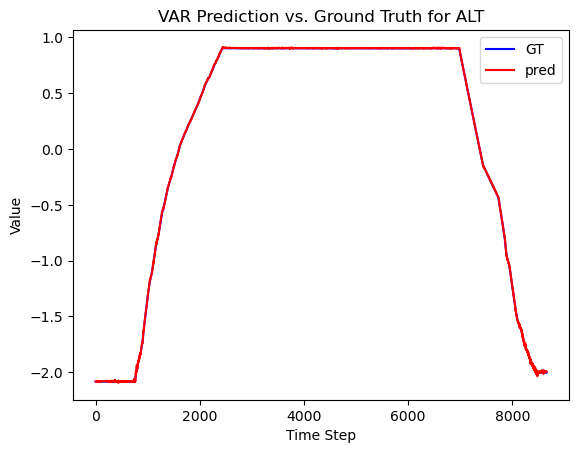

Variation from GT: 0.06744948616016243


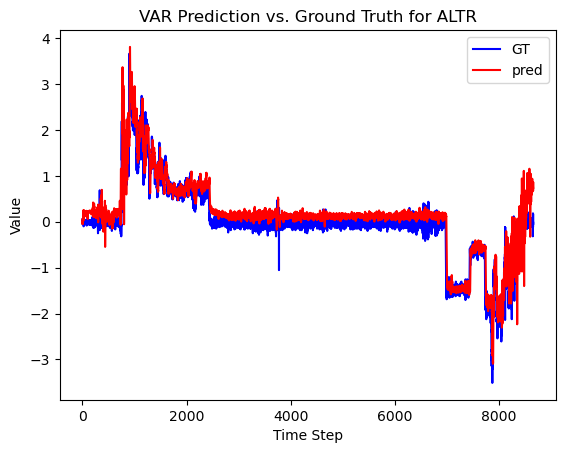

Variation from GT: 0.015024340526409153


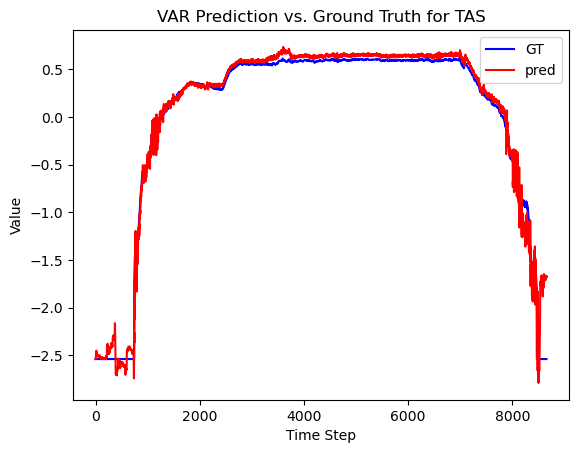

Variation from GT: 0.003219234952419597


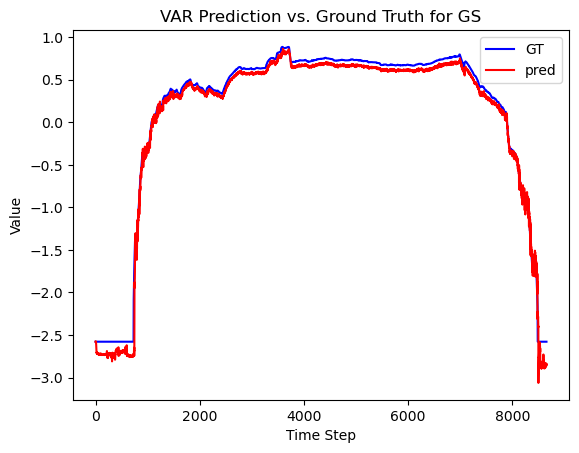

Variation from GT: 0.3164322829358193


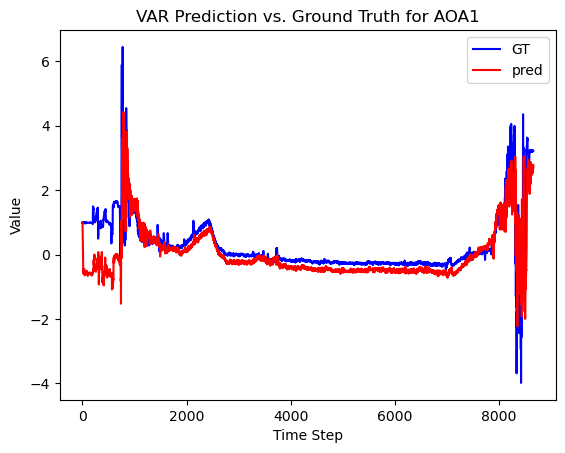

Variation from GT: 0.39233464800638657


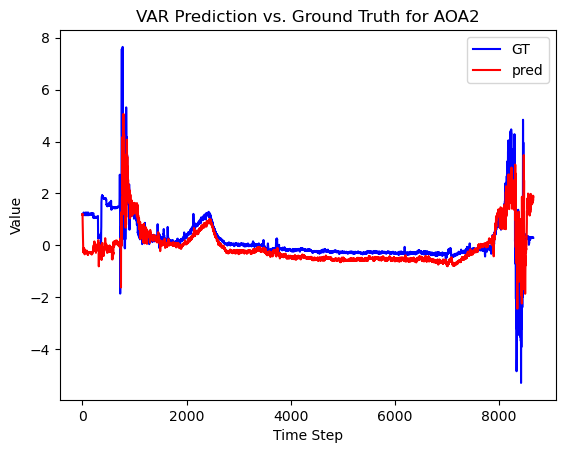

Variation from GT: 0.1221077551928149


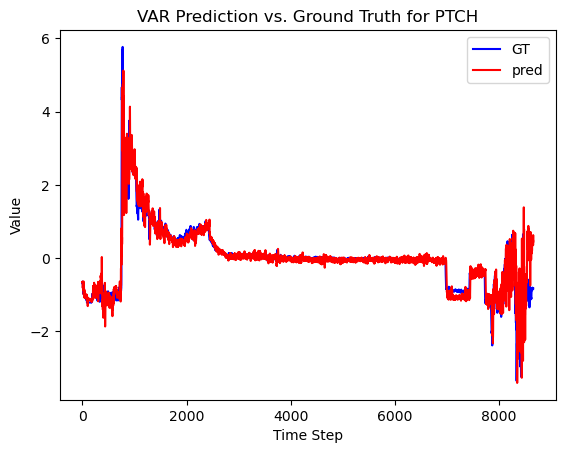

Variation from GT: 0.11993049300548303


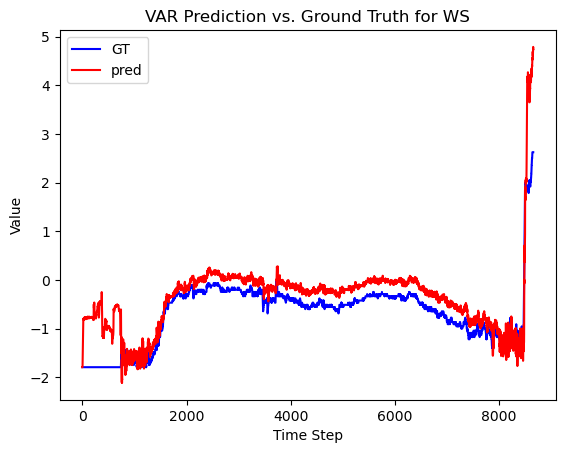

Variation from GT: 1.2938047705647455


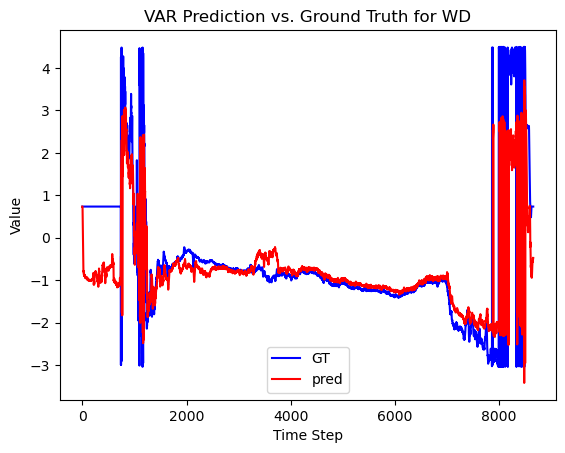

Variation from GT: 0.00035113257406069567


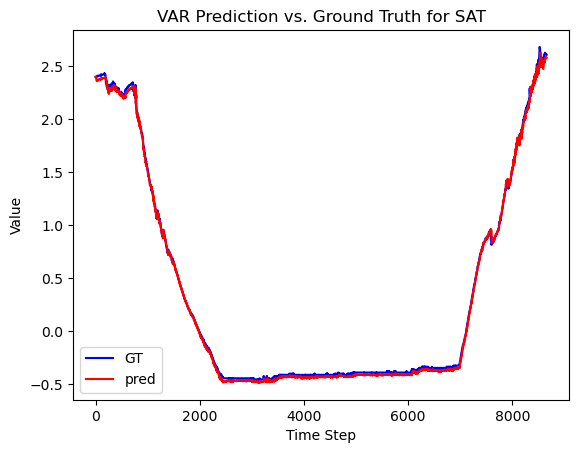

Variation from GT: 0.0014534159655051032


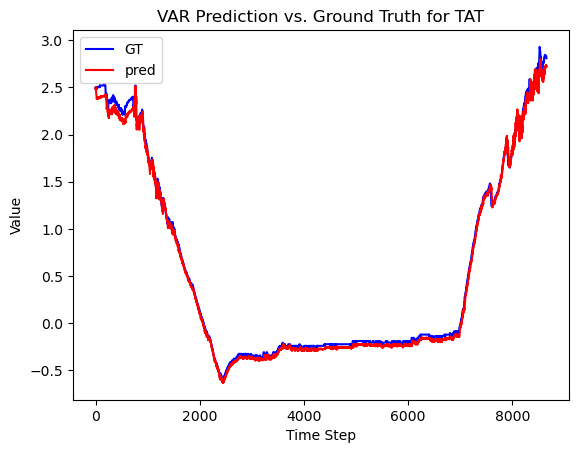

Variation from GT: 0.002435571479956728


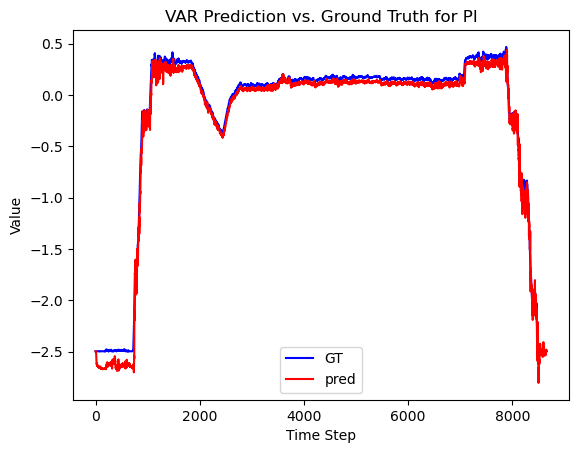

Variation from GT: 0.00019245527980931592


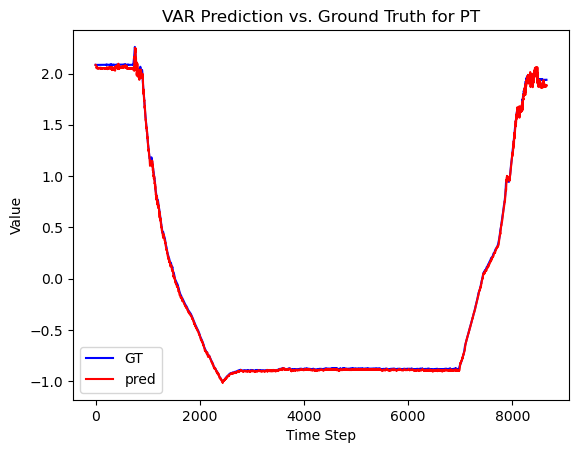

Variation from GT: 0.12214516403486843


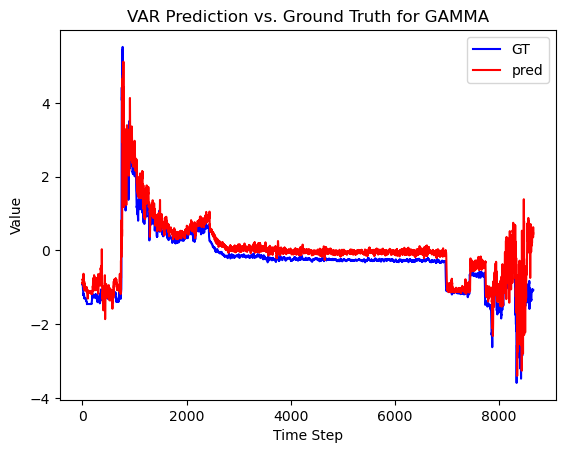

In [37]:
# 构建向量自回归模型
import pandas as pd
from statsmodels.tsa.api import VAR
import random

# 拟合VAR模型
decay_steps = 5
model = VAR(train_X)
results = model.fit(decay_steps)

# 打印模型的系数
VAR_params = results.params
print(VAR_params.shape)
# print(var_params)

# 打印模型预测结果
# test_X_tmp = test_X
# test_X = train_X
pred_steps = 15
test_X_pred = None
for rand_start in range(0, test_X.shape[0] - pred_steps - decay_steps + 1):
# rand_start = random.randint(0, train_X.shape[0] - decay_steps)
    pred_results = results.forecast(test_X[rand_start:rand_start+decay_steps], steps=pred_steps)
    if rand_start == 0:
        test_X_pred = np.vstack((test_X[:decay_steps], pred_results))
        # print(test_X_pred.shape)
    else:
        test_X_pred = np.vstack((test_X_pred, pred_results[-1, :]))
# print(test_X_pred.shape)
# print(f"Forecast based on data in [{rand_start}, {rand_start+decay_steps}]s")
# print(f"Variation from GT: {np.mean(np.var(pred_results - test_X[rand_start+decay_steps:rand_start+decay_steps+pred_steps], axis=0))}")

# plt.figure()
# plt.plot(test_X[rand_start+decay_steps:rand_start+decay_steps+pred_steps, 0])
# plt.show()

for idx in range(len(variable_list)):
    fig, ax = plt.subplots()
    # ax.scatter(range(pred_steps), test_X[rand_start+decay_steps:rand_start+decay_steps+pred_steps, idx], label = 'GT', color = 'blue')
    # ax.scatter(range(pred_steps), pred_results[:, idx], label = 'pred', color = 'red')
    ax.plot(test_X[:, idx], label = 'GT', color = 'blue')
    ax.plot(test_X_pred[:, idx], label = 'pred', color = 'red')
    print(f"Variation from GT: {np.mean(np.var(test_X_pred[:, idx] - test_X[:, idx], axis=0))}")
    # plt.xlim(0, pred_steps)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(f'VAR Prediction vs. Ground Truth for {variable_list[idx]}')
    plt.legend()
    plt.show()

# # 查看模型概况
# print(results.summary())